In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Dataset, TensorDataset
import os
import pytest
from google.colab import drive
import pandas as pd
import math
import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.init as init
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# auxiliary functions for data loading
def df_to_X_y(df):
  df_as_np = df.to_numpy()

  X = df_as_np[:-1, :] # daily values (open, high, low and close)
  Y = df_as_np[1:, -1] # the target is the closing price of the next day

  return X.astype(np.float32), Y.astype(np.float32)


def str_to_datetime(s): # used to convert the date into an index
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


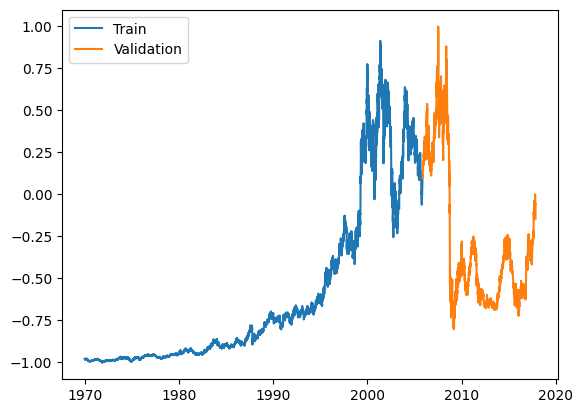

In [ ]:
drive.mount('/content/drive')
data_path = '/content/drive/Shared drives/Deep Learning/FinalProject/Data/' # modify path accordingly
df = pd.read_csv(data_path + "aa.us.csv") # use data following the same structure as this csv
results_path = '/content/drive/Shared drives/Deep Learning/FinalProject/Results/'

df['Date'] = df['Date'].apply(str_to_datetime)
df = df[['Date', 'Open', 'High', 'Low', 'Close']]
df.index = df.pop('Date')
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

q_80 = int(len(df['Close']) * .75)

# split training and testing data
train = df.iloc[:q_80, :]
test = df.iloc[q_80:, :]

# the dataset below are already np arrays
X_train, y_train = df_to_X_y(train)
X_test, y_test = df_to_X_y(test)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

plt.plot(train["Close"])
plt.plot(test["Close"])
plt.legend(['Train', 'Validation'])

In [ ]:
dataset_train = np.hstack((X_train, y_train))
dataset_test = np.hstack((X_test, y_test))
len_train = len(dataset_train)
len_test = len(dataset_test)
len_seq = 50

"""
structure of one element:

feature feature feature feature ignore
feature feature feature feature ignore
feature feature feature feature ignore
feature feature feature feature target

using sliding windows
right most columns are the closing price of the next day
the first for columns are the open, high, low and close of the current day
"""

class MyDataset(Dataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        x = self.data[index:index + self.window, :-1]  # keeping all features except the last column
        y = self.data[index+self.window, -1] # target from last element --> last column (target)
        return x, y

    def __len__(self):
        return len(self.data) - self.window

dataset_train = MyDataset(dataset_train, len_seq)
dataset_test = MyDataset(dataset_test, len_seq)

data_loader_train = DataLoader(dataset_train, batch_size=len_seq)
data_loader_test = DataLoader(dataset_test, batch_size=1) # loading one sequence at a time

In [ ]:
class StockLN(nn.Module):
    def __init__(self, input_dims, hidden_size, num_layers):
        super(StockLN, self).__init__()

        self.lstm = nn.LSTM(input_size=input_dims, hidden_size=hidden_size, num_layers=num_layers, dropout=0.3, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1) # for singlelabel the output must be 1
        self.do = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[-1,-1,:]
        x = self.fc1(x)
        x = self.do(x)
        x = self.fc2(x)
        return x

In [ ]:
def train_test_model(model, criterion, optimizer, train_loader, test_loader, epochs, tolerance):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    loss_list = []
    for epoch in range(epochs):
        model.train()
        total_step = len(train_loader)
        for i, (features, labels) in enumerate(train_loader):
            features = features.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(features)
            loss = criterion(outputs.squeeze(), labels[-1])

            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.7) # to avoid exploding gradient
            optimizer.step()

            loss_list.append(loss.item())
            if ((i+1) % 100 == 0) or (i==total_step-1):
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, epochs, i+1, total_step, loss.item()))

    # save the model checkpoint for transfer learning
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    torch.save(model.state_dict(), os.path.join(results_path, 'model.ckpt'))

    # testing
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)

            # network predictions
            outputs = model(features)

            within_tolerance = torch.abs(outputs.squeeze() - labels[-1]) <= tolerance
            print(outputs.squeeze(), labels[-1]) # this can be removed

            if within_tolerance == True:
                correct+=1

        total = len_test
        test_accuracy = 100 * correct / total
        print('Final test Accuracy of the model: {:.2f} %'.format(test_accuracy))


    return loss_list

def predict(model, train_loader, test_loader):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    model.eval()
    with torch.no_grad():
        total = 0
        predictions = []
        labels_plot = []

        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            # network predictions
            outputs = model(features)

            predictions.append(outputs.squeeze().cpu().numpy())
            labels_plot.append(labels[-1].cpu().numpy())

    plt.figure(figsize=(10, 5))
    plt.plot(predictions, label='Predictions', color='blue')
    plt.plot(labels_plot, label='Actual Labels', color='orange')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title('Model Predictions vs Actual Labels')
    plt.legend()
    plt.show()

    return predictions

Epoch [1/250], Step [100/181], Loss: 0.0382
Epoch [1/250], Step [181/181], Loss: 0.0328
Epoch [2/250], Step [100/181], Loss: 0.0266
Epoch [2/250], Step [181/181], Loss: 0.0069
Epoch [3/250], Step [100/181], Loss: 0.0039
Epoch [3/250], Step [181/181], Loss: 0.0446
Epoch [4/250], Step [100/181], Loss: 0.0004
Epoch [4/250], Step [181/181], Loss: 0.0059
Epoch [5/250], Step [100/181], Loss: 0.0065
Epoch [5/250], Step [181/181], Loss: 0.0077
Epoch [6/250], Step [100/181], Loss: 0.0120
Epoch [6/250], Step [181/181], Loss: 0.0117
Epoch [7/250], Step [100/181], Loss: 0.0168
Epoch [7/250], Step [181/181], Loss: 0.0294
Epoch [8/250], Step [100/181], Loss: 0.0047
Epoch [8/250], Step [181/181], Loss: 0.0002
Epoch [9/250], Step [100/181], Loss: 0.0014
Epoch [9/250], Step [181/181], Loss: 0.0069
Epoch [10/250], Step [100/181], Loss: 0.0000
Epoch [10/250], Step [181/181], Loss: 0.0041
Epoch [11/250], Step [100/181], Loss: 0.0127
Epoch [11/250], Step [181/181], Loss: 0.0030
Epoch [12/250], Step [100/18

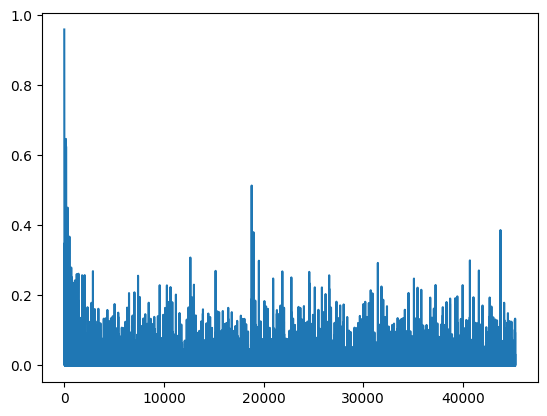

In [ ]:
model = StockLN(input_dims=4, hidden_size=32, num_layers=1) # this values proved empirically to be the best performing ones, an excel with different params can be found in the repo
criterion = nn.MSELoss(reduction="mean") # mean squared error loss for regression task
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_list = train_test_model(model, criterion, optimizer, data_loader_train, data_loader_test,epochs=250)
plt.plot(loss_list)

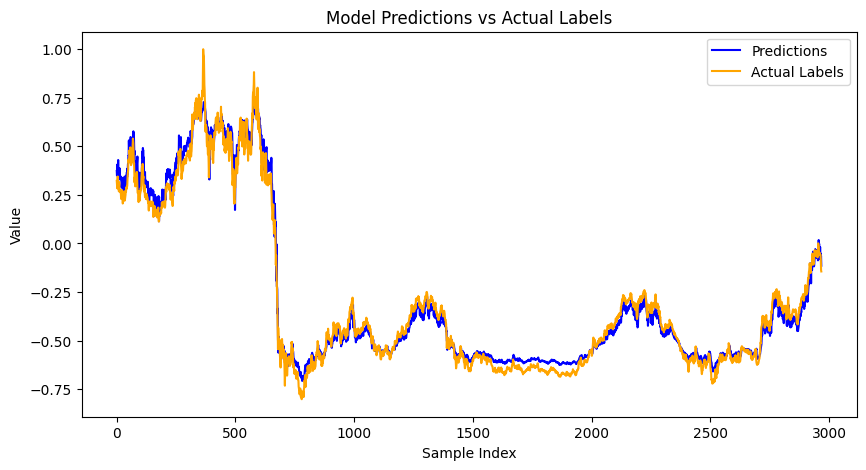

In [ ]:
predictions = predict(model, data_loader_train ,data_loader_test)